In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scienceplots
import scipy

import tensorstore as ts

plt.style.use(['science', 'no-latex'])

/Users/s/vault/neural_data/janelia/subject_05
SHAPE:,  (2880, 97766)


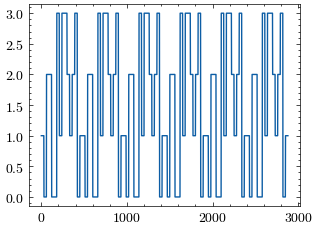

/Users/s/vault/neural_data/janelia/subject_06
SHAPE:,  (3780, 92538)


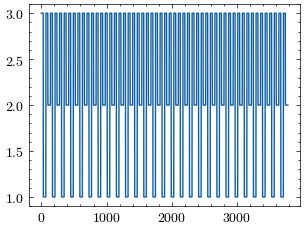

/Users/s/vault/neural_data/janelia/subject_16
SHAPE:,  (1877, 62737)
16


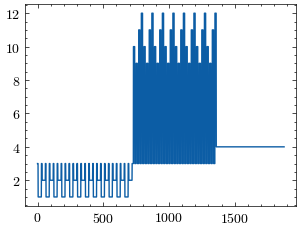

/Users/s/vault/neural_data/janelia/subject_17
SHAPE:,  (5554, 63922)
17


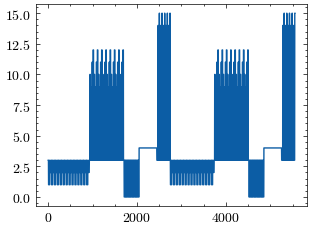

In [3]:
PATH = "/Users/s/vault/neural_data/janelia"
subject_id_list = [5, 6, 16, 17]
for subject_id in subject_id_list:
  h5_path = f"{PATH}/subject_{subject_id:02d}"
  print(h5_path)
  x = h5py.File(f"{h5_path}/TimeSeries.h5", "r")
  x = np.array(x['CellResp']).astype(np.float32)

  print("SHAPE:, ", x.shape)

  mat_path = f"{PATH}/subject_{subject_id:02d}/data_full.mat"
  data_struct = scipy.io.loadmat(mat_path)['data'][0, 0]

  # coordinates = data_struct['CellXYZ'].astype(np.float32)
  # behavioral_covariates = data_struct['Behavior_full'].T.astype(np.float32)

  if 'stimset' in data_struct.dtype.names:
    print(subject_id)

  plt.plot(data_struct['stim_full'].ravel())
  plt.show()


In [6]:
ds_janelia = ts.open({
    'open': True,
    'driver': 'zarr3',
    'kvstore': f'file://{PATH}/ts_files/subject_{subject_id}_traces.zarr'
}).result()

mat files

In [61]:
data_struct['stimset'][0, 0]

np.void((array(['PT'], dtype='<U2'), array([[1, 1],
       [2, 1]], dtype=uint8), array([[3, 1, 3, 2]], dtype=uint8), array([[100]], dtype=uint8), array([[   1, 3261]], dtype=uint16), array([[ 935, 4195]], dtype=uint16), array([[ 101, 3301]], dtype=uint16), array([[ 900, 4100]], dtype=uint16), array([[8, 8]], dtype=uint8)), dtype=[('name', 'O'), ('ij', 'O'), ('pattern', 'O'), ('period', 'O'), ('rawstarts', 'O'), ('rawstops', 'O'), ('starts', 'O'), ('stops', 'O'), ('nReps', 'O')])

In [ ]:
print('freq: --', data_struct['fpsec'].ravel()[0])
print('dur:  --', data_struct['timelists'][0, 0].ravel().max() / (1.97 * 60))

In [ ]:
conditions = [0, 1, 2, 3]
condition = 3
ix_by_condition = np.where(data_struct['stim_full'].ravel() == condition)[0]

In [ ]:
interval_ix = np.where(np.diff(ix_by_condition) != 1)[0]
condition_intervals = tuple()
condition_intervals_by_condition = tuple()
for i, j in zip(np.insert(interval_ix, 0, -1), np.insert(interval_ix, len(interval_ix), len(ix_by_condition)-1)):
  condition_intervals_by_condition = condition_intervals + ((int(ix_by_condition[i+1]), int(ix_by_condition[j])),)

In [ ]:
condition_intervals

Important features to save
- CellXYZ (n_neurons, 3)
- stim_full (1, n_t)
- Behavior_full (5, n_t)

In [ ]:
from zapbench import constants

constants.get_dataset_config(constants.DEFAULT_DATASET);

In [ ]:
def save_ts(x: np.ndarray, subject_id: str, data_type: str) -> None:
  """Save np array to ts."""
  spec = {
      'driver': 'zarr3',
      'kvstore': {'driver': 'file', 'path': f'{PATH_STORE}/subject_{subject_id}_{data_type}.zarr'},
      'metadata': {
          'shape': [*x.shape],
          'chunk_grid': {'name': 'regular', 'configuration': {'chunk_shape': [512, 512]}},
          'chunk_key_encoding': {'name': 'default'},
          'codecs': [{'name': 'bytes', 'configuration': {'endian': 'little'}}],
          'data_type': 'float32',
          'fill_value': 0.0
      }
  }
  ds = ts.open(spec, create=True).result()
  ds[...] = x

def save_janelia(subject_id: str) -> None:

  h5_path = f"{PATH_LOAD}/subject_{subject_id}/"
  x = h5py.File(f"{h5_path}/TimeSeries.h5", "r")
  x = np.array(x['CellResp']).astype(np.float32)
  save_ts(x, subject_id, "traces")

  mat_path = f"{PATH_LOAD}/subject_{subject_id}/data_full.mat"
  data_struct = scipy.io.loadmat(mat_path)['data'][0, 0]

  coordinates = data_struct['CellXYZ'].astype(np.float32)
  save_ts(coordinates, subject_id, "coordinates")
  behavioral_covariates = data_struct['Behavior_full'].T.astype(np.float32)
  save_ts(behavioral_covariates, subject_id, "behavioral_covariates")


def create_config():
  pass

Save

In [ ]:
PATH_LOAD = "/Users/s/vault/neural_data/janelia/"
PATH_STORE = "/Users/s/vault/neural_data/janelia/ts_files"

# save_janelia(14)

Load

In [ ]:
data_types = ["traces", "coordinates", "behavioral_covariates"]

for data_type in data_types:

  ds_janelia = ts.open({
      'open': True,
      'driver': 'zarr3',
      'kvstore': f'file://{PATH_STORE}/subject_{subject_id}_{data_type}.zarr'
  }).result()

  print(ds_janelia.shape)

In [ ]:
def generate_dataset_config(dataset_name: str) -> None:
  pass

DATASET_CONFIGS = {
    '[NAME]': {
        'condition_intervals': ( [SELF: UPDATE TO CORRECT INTERVALS]
            ((0, 649),),
            ((649, 2422),),
            ((2422, 3078),),
            ((3078, 3735),),
            ((3735, 5047),),
            ((5047, 5638),),
            ((5638, 6623),),
            ((6623, 7279),),
            ((7279, 7879),),
        ),
        'condition_names': (
            'taxis'
            'optomotor_response'
            'looming'
            'dark-flash response'
        ),
        'conditions_train': (0, 1, 3),
        'conditions_holdout': (2,),
        'timeseries_name': 'subject_{subject_id}',
        'covariate_series_name': '240930_stimuli_features', [BETTER NAME]
        'specs': {
            'subject_{subject_id}': {
                'kvstore': path_to_traces,
                'driver': 'zarr3',
                'transform': {
                    'input_exclusive_max': [[7879], 71721], [SHAPE HERE]
                    'input_inclusive_min': [0, 0],
                    'input_labels': ['t', 'f'],
                },
            },
        },
        'covariate_specs': {
            '240930_stimuli_features': { [SAME]
                'kvstore': (
                    'gs://zapbench-release/volumes/20240930/stimuli_features/' [PATH]
                ),
                'driver': 'zarr', [UPDATE DRIVER SPECS]
                'rank': 2,
                'metadata': {'shape': [7879, 26]},
                'transform': {
                    'input_inclusive_min': [0, 0],
                    'input_exclusive_max': [[7879], [26]],
                    'input_labels': ['t', 'f'],
                },
        },
        'min_max_values': {
            '240930_traces': (-0.25, 1.5), [SELF: CHECK THIS BEFORE SAVING, AND CLIP OFF IF NEEDED IN SAVE, OR MAYBE MAKE A PREPROCESSING FN]
        },
        'position_embedding_specs': { [SAME SET OF CHANGES HERE]
            '240930_traces': {
                'kvstore': (
                    'gs://zapbench-release/volumes/20240930/position_embedding/'
                ),
                'driver': 'zarr',
                'rank': 2,
                'metadata': {'shape': [71721, 192]},
                'transform': {
                    'input_inclusive_min': [0, 0],
                    'input_exclusive_max': [[71721], [192]],
                    'input_labels': ['f', 'a'],
                },
            }
        },
    },
}